# Data Visualisation in Timeseries Analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/data_visualisation.ipynb)

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.

## Synopsis

Visualisation is an essential component of data science and machine learning, used to emphasise patterns, structures and outliers hidden within large quantities of numerical data. The aim is to communicate key insights obtained through data analysis in a visual and intuitive way, such that they can be easily understood by other scientists, business professionals, managers and even the general public.

## Setup

Before proceeding, the following required libraries should be installed and imported.

In [ ]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install numpy
# ! pip install pandas
# ! pip install tensorflow
# ! pip install matplotlib

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data

In addition to the NAB dataset, we will use the `art_daily_small_noise.csv` file for training and the `art_daily_jump.csv` file for testing our model.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

The artificial timeseries data we will be working with are ordered, timestamped, single-valued metrics, with labeled periods of anomalous behaviour. To get a quick overview of what our training and test sets looks like, run the commands below:

In [3]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualise the data

### Timeseries data without anomalies

Suppose that we want to establish a suitable benchmark for an anomaly. Here is the data we will use for training:

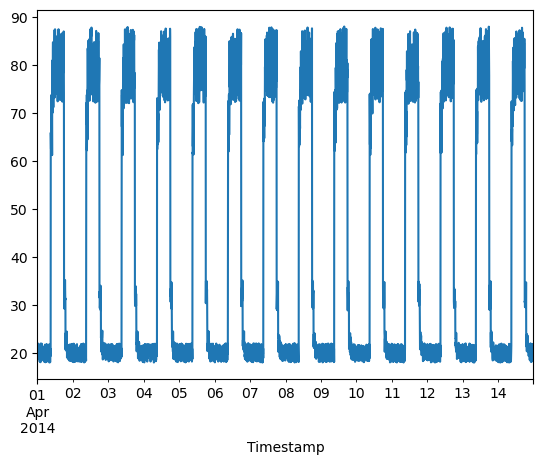

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.show()

### Timeseries data with anomalies

To test the autoencoder after training, we want to see whether the spike in our artificial test data will be detected as an anomaly:

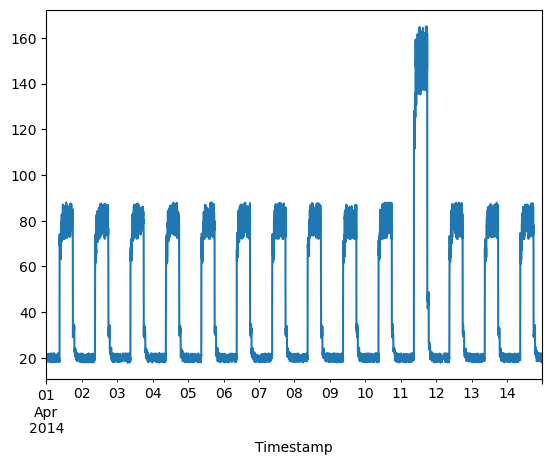

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.show()

## Prepare training data

Get the values from the training timeseries data file and normalise the `value` data. We have a `value` for every 5 minutes for 14 days.

In [6]:
# Normalise and save the mean and standard deviation we get for normalising test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print(df_training_value.head())

Number of training samples: 4032
                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173


## Create sequences

Create sequences combining `TIME_STEPS` contiguous data values from the training data.

In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

print(x_train[0:5])

Training input shape:  (3745, 288, 1)
[[[-0.85882857]
  [-0.72899302]
  [-0.84814772]
  ...
  [-0.86453747]
  [-0.81250829]
  [-0.79671155]]

 [[-0.72899302]
  [-0.84814772]
  [-0.72958579]
  ...
  [-0.81250829]
  [-0.79671155]
  [-0.78767946]]

 [[-0.84814772]
  [-0.72958579]
  [-0.731173  ]
  ...
  [-0.79671155]
  [-0.78767946]
  [-0.73706287]]

 [[-0.72958579]
  [-0.731173  ]
  [-0.75730984]
  ...
  [-0.78767946]
  [-0.73706287]
  [-0.77462891]]

 [[-0.731173  ]
  [-0.75730984]
  [-0.77645641]
  ...
  [-0.73706287]
  [-0.77462891]
  [-0.80183579]]]


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length` is 288 and `num_features` is 1.

In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

Please note that we are using `x_train` as both the input and the target since this is a reconstruction model.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 8s 154ms/step - loss: 0.6996 - val_loss: 0.2920
Epoch 2/50
27/27 [==============================] - 3s 112ms/step - loss: 0.1134 - val_loss: 0.0447
Epoch 3/50
27/27 [==============================] - 3s 112ms/step - loss: 0.0647 - val_loss: 0.0415
Epoch 4/50
27/27 [==============================] - 3s 112ms/step - loss: 0.0560 - val_loss: 0.0401
Epoch 5/50
27/27 [==============================] - 3s 110ms/step - loss: 0.0497 - val_loss: 0.0375
Epoch 6/50
27/27 [==============================] - 3s 112ms/step - loss: 0.0440 - val_loss: 0.0345
Epoch 7/50
27/27 [==============================] - 3s 112ms/step - loss: 0.0391 - val_loss: 0.0322
Epoch 8/50
27/27 [==============================] - 3s 111ms/step - loss: 0.0351 - val_loss: 0.0310
Epoch 9/50
27/27 [==============================] - 3s 109ms/step - loss: 0.0320 - val_loss: 0.0301
Epoch 10/50
27/27 [==============================] - 3s 111ms/step - loss: 0.0299 - val_loss: 0.0300

Plot training and validation loss to see how the training went.

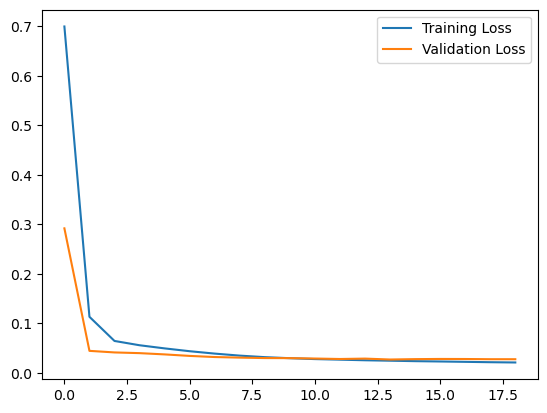

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

1. Find MAE loss on training samples.
2. Find maximum MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the `threshold` for anomaly detection.
3. If the reconstruction loss for a sample is greater than this `threshold` value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an `anomaly`.

118/118 [==============================] - 2s 16ms/step


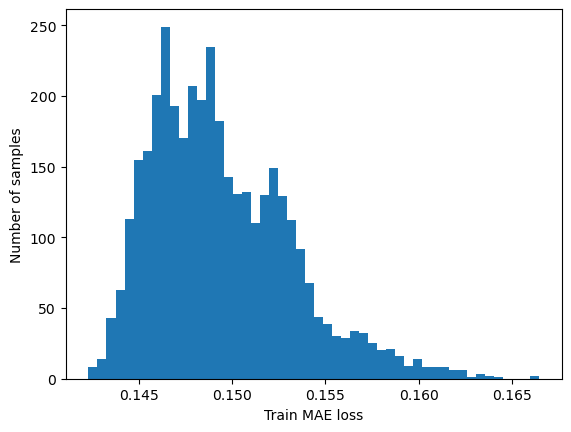

Reconstruction error threshold:  0.16647844360128705


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare reconstruction

To see how the model has reconstructed the first sample, run the code below. This is the 288 timesteps from day 1 of our training dataset.

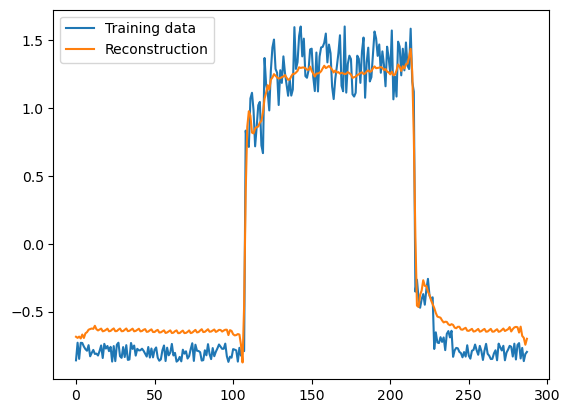

In [12]:
# Checking how the first sequence is learnt
plt.plot(x_train[0], label="Training data")
plt.plot(x_train_pred[0], label="Reconstruction")
plt.legend()
plt.show()

### Prepare test data

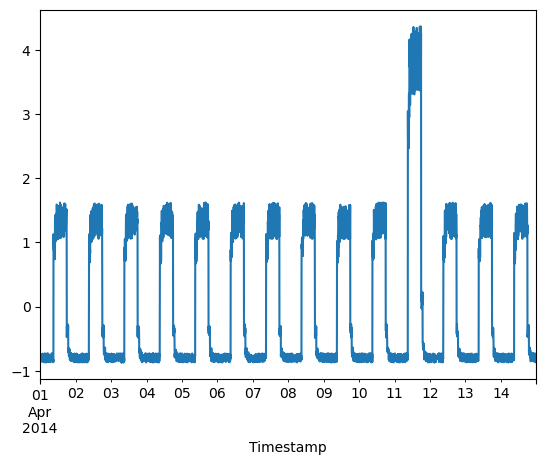

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 2s 16ms/step


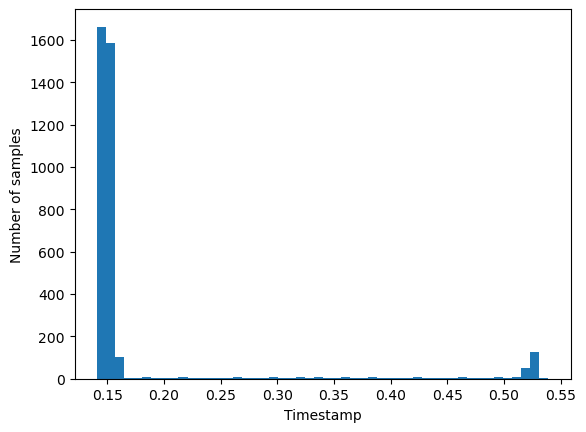

Number of anomaly samples:  394
Indices of anomaly samples:  (array([2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.xlabel("Timestamp")
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("Number of samples")
plt.xlabel("Timestamp")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

Having identified the anomalous data, we can now find the corresponding `timestamps` from the original test data using the following method:

Suppose `time_steps = 3`. For 10 training values, `x_train` will be:

```
0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
```

All points except the initial and final `time_steps - 1` values will appear in a total of `time_steps` samples. So, if we know that the samples `[(3, 4, 5), (4, 5, 6), (5, 6, 7)]` are anomalies, we can conclude that the datapoint `5` is an anomaly.

In [14]:
# Data i is an anomaly if samples [(i - time_steps + 1) to (i)] are anomalies.
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Finally, overlay the anomalies identified on the original test data plot.

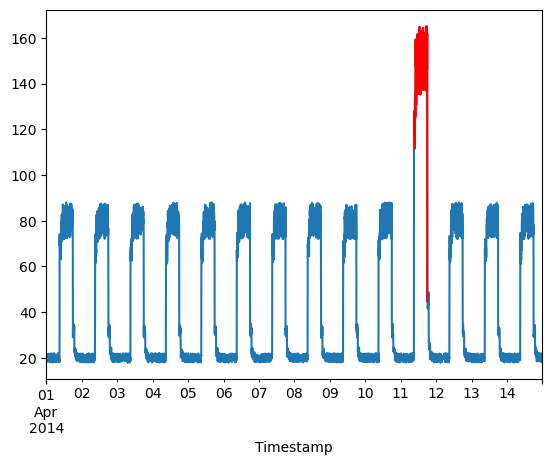

In [15]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.xlabel("Timestamp")
plt.show()

If you wish to get an overview of the remaining topics in this course, click the button below.

[![Back to main website](https://www.svgrepo.com/show/315449/enter.svg)](https://physdata.vercel.app/)